In [ ]:
import numpy as np
import os
import glob
import pandas as pd
import pickle
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import ExtraTreesRegressor
! pip install tensorflow_addons
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow_addons.metrics import RSquare
from sklearn.model_selection import GridSearchCV

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 37.2 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
cd drive/MyDrive/Colab\ Notebooks

/content/drive/MyDrive/Colab Notebooks


## All features for Emiliani2 with target Emiliani2 VHI

In [ ]:
target_region = 'Emiliani2'
csv_with_aggreg = "./features_with_aggregations_" + target_region + ".csv"

In [ ]:
all_features = pd.read_csv(csv_with_aggreg).rename(columns={'Unnamed: 0': 'date'})

In [ ]:
# merge with target values of Emiliani2
csv_target = "./csv/Emiliani2.csv"
target = pd.read_csv(csv_target).rename(columns={'Unnamed: 0': 'date'})

# remove dates not available in features
target = target[target['date'] <= all_features['date'].iloc[-1]]

target_df = pd.merge(all_features, target, on=['date'])['mean'].to_frame()

In [ ]:
# remove the date column
features_df = all_features.iloc[:,1:]

In [ ]:
idx_dic = {}
for col in features_df.columns:
    idx_dic[col] = features_df.columns.get_loc(col)
print('\n'.join(f'{value}: {key}' for key, value in idx_dic.items()))

Features chosen by wrapper on ExtraTrees: 
0: cyclostationary_mean_Emiliani2_tg
1: cyclostationary_mean_Emiliani2_rr
2: cyclostationary_mean_Emiliani2_tg_1w
3: cyclostationary_mean_Emiliani2_tg_4w
4: cyclostationary_mean_Emiliani2_tg_8w
5: cyclostationary_mean_Emiliani2_rr_4w
6: cyclostationary_mean_Emiliani2_rr_8w
7: cyclostationary_mean_Emiliani2_rr_12w


Features chosen by forward CMI: 
0: cyclostationary_mean_Emiliani2_tg
1: cyclostationary_mean_Emiliani2_tg_1w
2: cyclostationary_mean_Emiliani2_tg_4w
3: cyclostationary_mean_Emiliani2_tg_8w
4: cyclostationary_mean_Emiliani2_tg_24w
5: cyclostationary_mean_Emiliani2_rr_8w
6: cyclostationary_mean_Emiliani2_rr_12w
7: cyclostationary_mean_Emiliani2_rr_16w


In [ ]:
scaler_f = StandardScaler()
scaler_t = StandardScaler()

In [ ]:
train_perc=0.42 # training data from 2001-01 to 2009-12 included
tot_rows = len(features_df)
# valid_perc = test_perc
valid_perc = 0.232 # validation data from 2010-01 to 2014-12 included, test until 2019-12 included

features_train = features_df.iloc[0:int(tot_rows*train_perc)-1,:]
target_train = target_df.iloc[0:int(tot_rows*train_perc)-1,:]

# fit the scalers on training data
scaler_f.fit(features_train)
scaler_t.fit(target_train)

# scale all the dataset
features_df[features_df.columns] = scaler_f.transform(features_df[features_df.columns])
target_df[target_df.columns] = scaler_t.transform(target_df[target_df.columns])

X_train = features_df.iloc[0:int(tot_rows*train_perc)-1,:]
#228 samples for validation and for test
X_valid = features_df.iloc[int(tot_rows*train_perc)-1:int(tot_rows*(valid_perc+train_perc))]
X_test = features_df.iloc[int(tot_rows*(valid_perc+train_perc)):int(tot_rows*(valid_perc*2+train_perc))]

y_train = target_df.iloc[0:int(tot_rows*train_perc)-1,:]
y_valid = target_df.iloc[int(tot_rows*train_perc)-1:int(tot_rows*(valid_perc+train_perc))]
y_test = target_df.iloc[int(tot_rows*(valid_perc+train_perc)):int(tot_rows*(valid_perc*2+train_perc))]

X_train_valid = pd.concat([X_train, X_valid])
y_train_valid = pd.concat([y_train,y_valid])

print("The last ", round(1-(train_perc+valid_perc*2),2),"% of data is left unused,", 
      tot_rows - int(tot_rows*(valid_perc*2+train_perc)),"samples")

print("Total numer of samples used: ", round(len(features_df) * (train_perc + 2*valid_perc)))
print("Train samples: ", len(y_train))
print("Validation samples and test samples: ", len(y_valid))
print("Training and validation samples: ", len(y_train_valid))
print("Training data from 2001-01 to 2009-12 included, train %: ", train_perc)
print("Valid data from 2010-01 to 2014-12 included, test until 2019-12 included, % each: ", valid_perc)

The last  0.12 % of data is left unused, 114 samples
Total numer of samples used:  867
Train samples:  411
Validation samples and test samples:  228
Training and validation samples:  639
Training data from 2001-01 to 2009-12 included, train %:  0.42
Valid data from 2010-01 to 2014-12 included, test until 2019-12 included, % each:  0.232


## Wrapper Feature Selection
Forward wrapper feature selection to detect the best features

In [ ]:
# linear regression model
sfs_forward = SequentialFeatureSelector(LinearRegression(), n_features_to_select = 8, direction="forward").fit(X_train, y_train)
chosen_features = features_df.iloc[:,sfs_forward.get_support()]
chosen_features

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 30, stop = 200, num = 40)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
#max_depth = [int(x) for x in np.linspace(10, 110, num = 5)]
#max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 3, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
# bootstrap = [True]
# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               #'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               #'bootstrap': bootstrap
              }

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor
# extra trees regressor

# iterate for all values of features i and choose the one perfoming better in cross validation
score = 0
for i in range (1, 14):
  # choose the best i features on a regressor with default parameters
  sfs_forward = SequentialFeatureSelector(ExtraTreesRegressor(random_state=42), 
                                          n_features_to_select = i, direction="forward").fit(X_train.values, y_train.values.ravel())
  chosen_features = features_df.iloc[:,sfs_forward.get_support()]
  ext = ExtraTreesRegressor(random_state=42)

  # find the best parameters with grid search for the chosen features
  opt = GridSearchCV(estimator=ext, param_grid = param_grid, verbose = 0)
  opt.fit(X_train_valid.iloc[:,np.flatnonzero(sfs_forward.get_support())].values, y_train_valid.values.ravel())
  # if the score is better than the old one, save current features and parameters
  if (opt.best_score_ > score):
    score = opt.best_score_
    optimal_num_features = i
    best_parameters = opt.best_params_
    chosen_features_ids = np.flatnonzero(sfs_forward.get_support())
    print(" New best score: ", round(opt.best_score_,3), "\n", "Num features: ", str(i), "\n")
# best score with 8 features, 0.187 

 New best score:  0.02 
 Num features:  1 

 New best score:  0.108 
 Num features:  2 

 New best score:  0.183 
 Num features:  4 

 New best score:  0.187 
 Num features:  8 



In [ ]:
np.flatnonzero(sfs_forward.get_support())

array([ 0,  1,  2,  3,  4,  9, 10, 11])

In [ ]:
opt.best_params_

{'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 64}

In [ ]:
# score with features chosen by CMI

ext = ExtraTreesRegressor(random_state=42)
opt_CMI = GridSearchCV(estimator=ext, param_grid = param_grid, verbose = 0)

# take only the indices of the chosen features
opt_CMI.fit(X_train_valid.iloc[:,[0, 2, 3, 4, 7, 10, 11, 12]].values, y_train_valid.values.ravel())

# mean cross-validated score of the best_estimator
print(" Score with best features chosen by CMI: ", round(opt_CMI.best_score_,3), "\n")

 Score with best features chosen by CMI:  0.149 



In [ ]:
opt_CMI.best_params_

{'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 130}

In [ ]:
# score with all features, same grid search

ext = ExtraTreesRegressor(random_state=42)
opt_all = GridSearchCV(estimator=ext, param_grid = param_grid, verbose = 0)

opt_all.fit(X_train_valid.values, y_train_valid.values.ravel())
print(" Score with all features: ", round(opt_all.best_score_,3), "\n")

 Score with all features:  0.143 



In [ ]:
opt_all.best_params_

{'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 134}

In [ ]:
# chosen features wrapper
best_rf = ExtraTreesRegressor(random_state=42, max_features = 'sqrt', min_samples_leaf = 2, min_samples_split = 2, n_estimators = 64)
best_rf.fit(X_train_valid.iloc[:,[0,  1,  2,  3,  4,  9, 10, 11]].values, y_train_valid.values.ravel())

# chosen features CMI
CMI_rf = ExtraTreesRegressor(random_state=42, max_features = 'sqrt', min_samples_leaf = 1, min_samples_split = 5, n_estimators = 130)
CMI_rf.fit(X_train_valid.iloc[:,[0, 2, 3, 4, 7, 10, 11, 12]].values, y_train_valid.values.ravel())

# all features
all_rf = ExtraTreesRegressor(random_state=42, max_features = 'auto', min_samples_leaf = 1, min_samples_split = 5, n_estimators = 134)
all_rf.fit(X_train_valid.values, y_train_valid.values.ravel())

BOLD = '\033[1m'
END = '\033[0m'

rf_mae = mean_absolute_error(y_test.values.ravel(), best_rf.predict(X_test.iloc[:,[0,  1,  2,  3,  4,  9, 10, 11]].values))
rf_mse = mean_squared_error(y_test.values.ravel(), best_rf.predict(X_test.iloc[:,[0,  1,  2,  3,  4,  9, 10, 11]].values))
r2_test = best_rf.score(X_test.iloc[:,[0,  1,  2,  3,  4,  9, 10, 11]].values, y_test.values.ravel())
r2_train = best_rf.score(X_train_valid.iloc[:,[0,  1,  2,  3,  4,  9, 10, 11]].values, y_train_valid.values.ravel())
print(" ExtraTreesRegressor (parameters from cross valid) features from wrapper: ")
print(" MAE: ", round(rf_mae,3), "\n", "MSE: ", round(rf_mse,3), "\n","R2_test: ", BOLD + str(round(r2_test,3)) + END, "\n", "R2_train: ", round(r2_train,3))

rf_mae = mean_absolute_error(y_test.values.ravel(), CMI_rf.predict(X_test.iloc[:,[0, 2, 3, 4, 7, 10, 11, 12]].values))
rf_mse = mean_squared_error(y_test.values.ravel(), CMI_rf.predict(X_test.iloc[:,[0, 2, 3, 4, 7, 10, 11, 12]].values))
r2_test = CMI_rf.score(X_test.iloc[:,[0, 2, 3, 4, 7, 10, 11, 12]].values, y_test.values.ravel())
r2_train = CMI_rf.score(X_train_valid.iloc[:,[0, 2, 3, 4, 7, 10, 11, 12]].values, y_train_valid.values.ravel())
print(" ExtraTreesRegressor (parameters from cross valid) features from CMI: ")
print(" MAE: ", round(rf_mae,3), "\n", "MSE: ", round(rf_mse,3), "\n","R2_test: ",BOLD + str(round(r2_test,3)) + END, "\n", "R2_train: ", round(r2_train,3))

rf_mae = mean_absolute_error(y_test.values.ravel(), all_rf.predict(X_test.values))
rf_mse = mean_squared_error(y_test.values.ravel(), all_rf.predict(X_test.values))
r2_test = all_rf.score(X_test.values, y_test.values.ravel())
r2_train = all_rf.score(X_train_valid.values, y_train_valid.values.ravel())
print(" ExtraTreesRegressor (parameters from cross valid) all features: ")
print(" MAE: ", round(rf_mae,3), "\n", "MSE: ", round(rf_mse,3), "\n","R2_test: ",BOLD + str(round(r2_test,3)) + END, "\n", "R2_train: ", round(r2_train,3))

 ExtraTreesRegressor (parameters from cross valid) features from wrapper: 
 MAE:  0.584 
 MSE:  0.51 
 R2_test:  0.259 
 R2_train:  0.715
 ExtraTreesRegressor (parameters from cross valid) features from CMI: 
 MAE:  0.602 
 MSE:  0.548 
 R2_test:  0.203 
 R2_train:  0.87
 ExtraTreesRegressor (parameters from cross valid) all features: 
 MAE:  0.579 
 MSE:  0.521 
 R2_test:  0.243 
 R2_train:  0.977


## Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# tutte le features
X_train_all = X_train_valid
X_test_all = X_test

reg = LinearRegression().fit(X_train_all, y_train_valid)
print("Linear Regression : ")
print("R2_train all: ", round(reg.score(X_train_all, y_train_valid),3))
print("R2_test all: ", BOLD + str(round(reg.score(X_test_all, y_test),3)) + END)
print("MAE all: ", round(mean_absolute_error(y_test,reg.predict(X_test_all)),3))
print("MSE all: ", round(mean_squared_error(y_test,reg.predict(X_test_all),squared=False),3))
print('\n')

# features chosen by CMI
X_train_chosenfeat = X_train_all.iloc[:,[0, 2, 3, 4, 7, 10, 11, 12]]
X_test_chosenfeat = X_test_all.iloc[:,[0, 2, 3, 4, 7, 10, 11, 12]]
reg = LinearRegression().fit(X_train_chosenfeat, y_train_valid)
print("R2_train CMI: ", round(reg.score(X_train_chosenfeat, y_train_valid),3))
print("R2_test CMI: ", BOLD + str(round(reg.score(X_test_chosenfeat, y_test),3)) + END)
print("MAE CMI: ", round(mean_absolute_error(y_test,reg.predict(X_test_chosenfeat)),3))
print("MSE CMI: ", round(mean_squared_error(y_test,reg.predict(X_test_chosenfeat),squared=False),3))
print('\n')

# features chosen by wrapper feature selection on Extra Trees
X_train_chosenfeat = X_train_all.iloc[:,[0,  1,  2,  3,  4,  9, 10, 11]]
X_test_chosenfeat = X_test_all.iloc[:,[0,  1,  2,  3,  4,  9, 10, 11]]
reg = LinearRegression().fit(X_train_chosenfeat, y_train_valid)
print("R2_train wrap: ", round(reg.score(X_train_chosenfeat, y_train_valid),3))
print("R2_test wrap: ", BOLD + str(round(reg.score(X_test_chosenfeat, y_test),3)) + END)
print("MAE wrap: ", round(mean_absolute_error(y_test,reg.predict(X_test_chosenfeat)),3))
print("MSE wrap: ", round(mean_squared_error(y_test,reg.predict(X_test_chosenfeat),squared=False),3))

Linear Regression : 
R2_train all:  0.219
R2_test all:  0.25
MAE all:  0.574
MSE all:  0.719


R2_train CMI:  0.206
R2_test CMI:  0.233
MAE CMI:  0.577
MSE CMI:  0.727


R2_train wrap:  0.209
R2_test wrap:  0.254
MAE wrap:  0.572
MSE wrap:  0.716


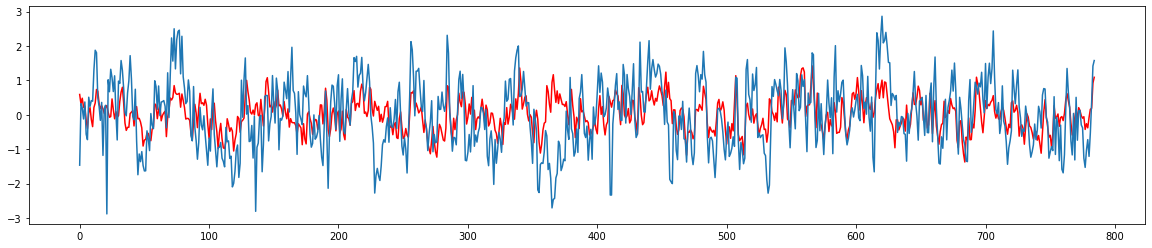

In [ ]:
# training prediction before (training + validation)

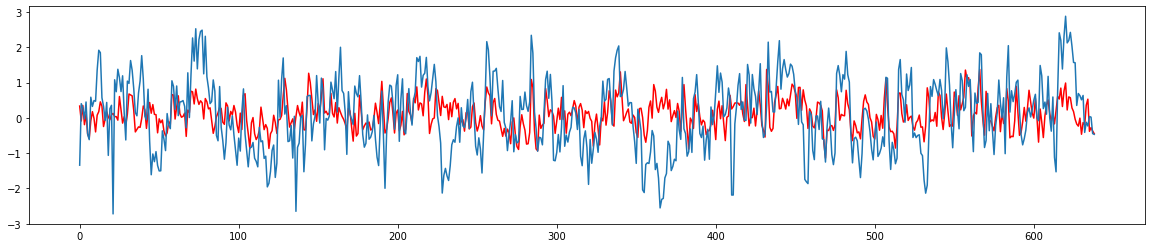

In [ ]:
X_train_chosenfeat = X_train_valid.iloc[:,[0, 8]]

reg = LinearRegression().fit(X_train_chosenfeat, y_train_valid)
# plot prediction on train + validation
prediction = reg.predict(X_train_chosenfeat)

plt.plot(prediction, color='red')
plt.plot(y_train_valid)

plt.rcParams["figure.figsize"] = (20,4)
plt.show()

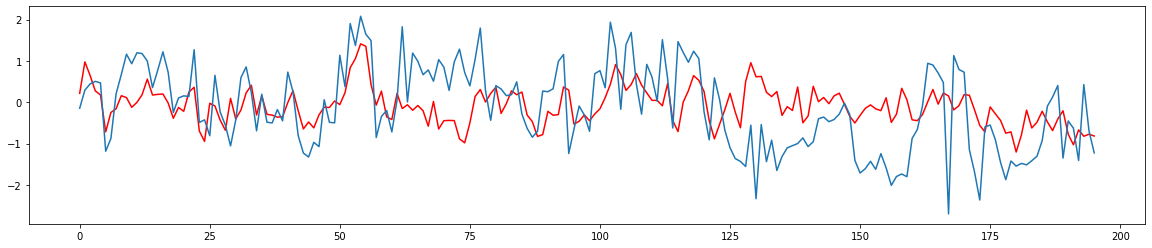

In [ ]:
# test prediction before

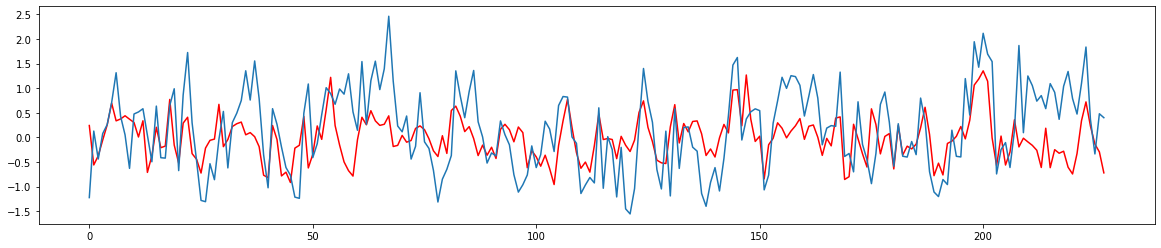

In [ ]:
X_test_chosenfeat = X_test.iloc[:,[0, 8]]

prediction = reg.predict(X_test_chosenfeat)

plt.plot(prediction, color='red')
y_test.reset_index(drop = True, inplace = True)
plt.plot(y_test)

plt.rcParams["figure.figsize"] = (15,4)
plt.show()

# Non linear models

## Functions

In [72]:
def feed_forward(num_units):
  # learning rate
  lr = 1e-3

  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(units=num_units, activation=tf.keras.activations.relu))
  model.add(tf.keras.layers.Dense(units = 1))

  metrics = [tf.keras.metrics.MeanAbsoluteError()]

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = lr),
                loss='mse',
                metrics=metrics)
  
  return model

## With all features

### Extra Tree Regressor

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 30, stop = 250, num = 60)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
#max_depth = [int(x) for x in np.linspace(10, 110, num = 5)]
#max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 3, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
# bootstrap = [True]
# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               #'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               #'bootstrap': bootstrap
              }

In [ ]:
# search of best parameters for extra Trees through 5-fold cross validation

ext = ExtraTreesRegressor(random_state=42)

opt = GridSearchCV(estimator=ext, param_grid = param_grid, verbose = 2)

opt.fit(X_train_valid.values, y_train_valid.values.ravel())

In [ ]:
opt.best_params_

{'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 80}

In [ ]:
# search of best parameters for extra Trees through fixed validation

from sklearn.model_selection import PredefinedSplit

ext = ExtraTreesRegressor(random_state=42)

split_index = [-1 if x in X_train.index else 0 for x in X_train_valid.index]

ps = PredefinedSplit(test_fold = split_index)
opt = GridSearchCV(estimator=ext, cv=ps, param_grid = param_grid, verbose = 2)

opt.fit(X_train_valid.values, y_train_valid.values.ravel())

In [ ]:
opt.best_params_

{'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 103}

In [ ]:
# train rfc on training + validation set and evaluate them on test set 

# score with parameters obtained by fixed validation 
rfc_fixed_valid= ExtraTreesRegressor(random_state=42, max_features = 'sqrt', min_samples_leaf = 1, min_samples_split = 2, n_estimators = 103)
rfc_fixed_valid.fit(X_train_valid.values, y_train_valid.values.ravel())

rf_mae = mean_absolute_error(y_test.values.ravel(), rfc_fixed_valid.predict(X_test.values))
rf_mse = mean_squared_error(y_test.values.ravel(), rfc_fixed_valid.predict(X_test.values))
r2_test = rfc_fixed_valid.score(X_test.values, y_test.values.ravel())
r2_train = rfc_fixed_valid.score(X_train_valid.values, y_train_valid.values.ravel())

print(" ExtraTreesRegressor (parameters from fixed valid): ")
print(" MAE: ", round(rf_mae,3), "\n", "MSE: ", round(rf_mse,3), "\n","R2_test: ",round(r2_test,3), "\n", "R2_train: ", round(r2_train,3))

# score with parameters obtained by cross validation 
rfc_cross_valid= ExtraTreesRegressor(random_state=42, max_features = 'auto', min_samples_leaf = 1, min_samples_split = 2, n_estimators = 80)
rfc_cross_valid.fit(X_train_valid.values, y_train_valid.values.ravel())

rf_mae = mean_absolute_error(y_test.values.ravel(), rfc_cross_valid.predict(X_test.values))
rf_mse = mean_squared_error(y_test.values.ravel(), rfc_cross_valid.predict(X_test.values))
r2_test = rfc_cross_valid.score(X_test.values, y_test.values.ravel())
r2_train = rfc_cross_valid.score(X_train_valid.values, y_train_valid.values.ravel())

print(" ExtraTreesRegressor (parameters from cross valid): ")
print(" MAE: ", round(rf_mae,3), "\n", "MSE: ", round(rf_mse,3), "\n","R2_test: ",round(r2_test,3), "\n", "R2_train: ", round(r2_train,3))

 ExtraTreesRegressor (parameters from fixed valid): 
 MAE:  0.598 
 MSE:  0.539 
 R2_test:  0.217 
 R2_train:  1.0
 ExtraTreesRegressor (parameters from cross valid): 
 MAE:  0.577 
 MSE:  0.522 
 R2_test:  0.241 
 R2_train:  1.0


### FFNN

In [108]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

ffnn_val = feed_forward(4)

hist_val = ffnn_val.fit(X_train.values, y_train.values, shuffle=False, epochs=1000, 
                        validation_data=(X_valid.values, y_valid.values), verbose = 0)

Text(0, 0.5, 'loss')

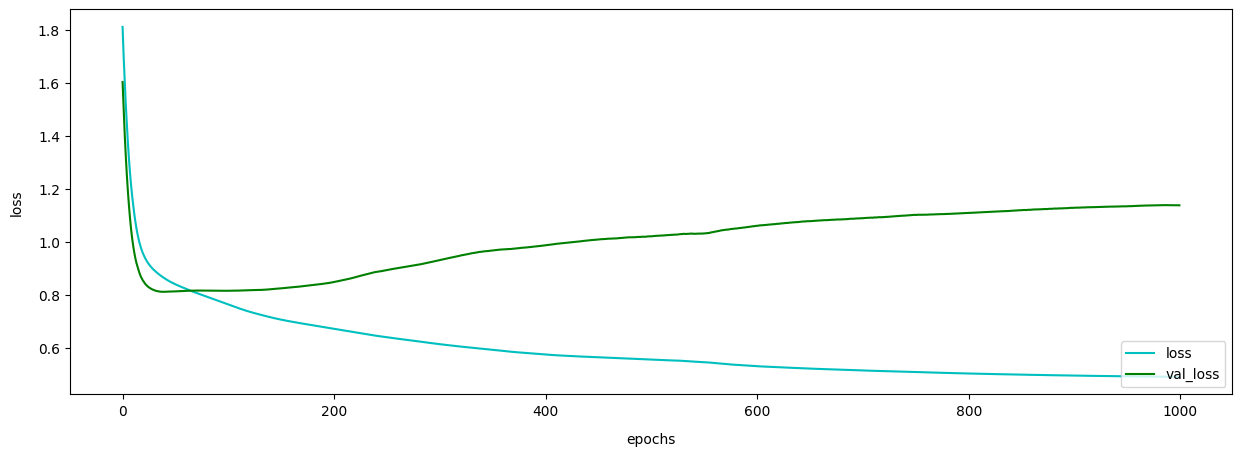

In [109]:
plt.plot(hist_val.history['loss'], 'c', label= "loss")
plt.plot(hist_val.history['val_loss'],'g', label= "val_loss")
plt.style.use('default')
plt.legend(loc="lower right")
plt.rcParams["figure.figsize"] = (15,5)

plt.xlabel('epochs', labelpad=10)
plt.ylabel('loss', labelpad=10)

In [116]:
ffnn = feed_forward(4)
ffnn.fit(X_train_valid, y_train_valid, shuffle=False, epochs=200, verbose = 0)

ffnn_MAE = mean_absolute_error(y_test.values, ffnn.predict(X_test.values))
ffnn_MSE = mean_squared_error(y_test.values, ffnn.predict(X_test.values))

metric = RSquare()
metric.update_state(y_test.values, ffnn.predict(X_test.values))
r2_test = metric.result()
r2_test.numpy()

metric = RSquare()
metric.update_state(y_train_valid, ffnn.predict(X_train_valid))
r2_train = metric.result()
r2_train.numpy()
print (" FFNN all features:")
print(" MAE: ", round(ffnn_MAE,3), "\n", "MSE: ", round(ffnn_MSE,3), "\n",
      "R2_test: ",round(r2_test.numpy(),3), "\n", "R2_train: ", round(r2_train.numpy(),3))

20/20 [==============================] - 0s 850us/step
 FFNN all features:
 MAE:  0.587 
 MSE:  0.522 
 R2_test:  0.243 
 R2_train:  0.295


## With chosen features

### Extra Tree Regressor

In [53]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 200, num = 40)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
#max_depth = [int(x) for x in np.linspace(10, 110, num = 5)]
#max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 25, 50, 100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               #'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               #'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap
               }            

In [54]:
ext = ExtraTreesRegressor(random_state=42)

opt_CMI = GridSearchCV(estimator=ext, param_grid = param_grid, verbose = 0)

opt_CMI.fit(X_train_valid.iloc[:,[0, 2, 3, 4, 7, 10, 11, 12]].values, y_train_valid.values.ravel())

GridSearchCV(estimator=ExtraTreesRegressor(random_state=42),
             param_grid={'bootstrap': [True, False],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_split': [2, 5, 10, 25, 50, 100],
                         'n_estimators': [10, 14, 19, 24, 29, 34, 39, 44, 48,
                                          53, 58, 63, 68, 73, 78, 83, 87, 92,
                                          97, 102, 107, 112, 117, 122, 126, 131,
                                          136, 141, 146, 151, ...]})

In [55]:
opt_CMI.best_params_

{'bootstrap': False,
 'max_features': 'sqrt',
 'min_samples_split': 10,
 'n_estimators': 126}

In [56]:
opt_CMI.best_score_

0.1583426753263639

In [57]:
# search of best parameters for extra Trees through 5-fold cross validation

ext = ExtraTreesRegressor(random_state=42)

opt_wrap = GridSearchCV(estimator=ext, param_grid = param_grid, verbose = 0)

opt_wrap.fit(X_train_valid.iloc[:,[0, 2, 3, 4, 9, 10, 11, 1]].values, y_train_valid.values.ravel())

GridSearchCV(estimator=ExtraTreesRegressor(random_state=42),
             param_grid={'bootstrap': [True, False],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_split': [2, 5, 10, 25, 50, 100],
                         'n_estimators': [10, 14, 19, 24, 29, 34, 39, 44, 48,
                                          53, 58, 63, 68, 73, 78, 83, 87, 92,
                                          97, 102, 107, 112, 117, 122, 126, 131,
                                          136, 141, 146, 151, ...]})

In [58]:
opt_wrap.best_params_

{'bootstrap': True,
 'max_features': 'auto',
 'min_samples_split': 2,
 'n_estimators': 58}

In [59]:
opt_wrap.best_score_

0.1782227134649338

In [70]:
# train rfc on training + validation set and evaluate them on test set 

rfc_CMI= ExtraTreesRegressor(random_state=42, max_features = 'sqrt', min_samples_split = 10, n_estimators = 126)
rfc_CMI.fit(X_train_valid.iloc[:,[0, 2, 3, 4, 7, 10, 11, 12]].values, y_train_valid.values.ravel())

rfc_wrap= ExtraTreesRegressor(random_state=42, max_features = 'sqrt', min_samples_split = 10, n_estimators = 126)
rfc_wrap.fit(X_train_valid.iloc[:,[0, 2, 3, 4, 9, 10, 11, 1]].values, y_train_valid.values.ravel())

# score with parameters obtained by cross validation 

rf_mae = mean_absolute_error(y_test.values.ravel(), rfc_CMI.predict(X_test.iloc[:,[0, 2, 3, 4, 7, 10, 11, 12]].values))
rf_mse = mean_squared_error(y_test.values.ravel(), rfc_CMI.predict(X_test.iloc[:,[0, 2, 3, 4, 7, 10, 11, 12]].values))
r2_test = rfc_CMI.score(X_test.iloc[:,[0, 2, 3, 4, 7, 10, 11, 12]].values, y_test.values.ravel())
r2_train = rfc_CMI.score(X_train_valid.iloc[:,[0, 2, 3, 4, 7, 10, 11, 12]].values, y_train_valid.values.ravel())

print(" ExtraTreesRegressor (features from CMI): ")
print(" MAE: ", round(rf_mae,3), "\n", "MSE: ", round(rf_mse,3), "\n","R2_test: ",BOLD,round(r2_test,3), END,"\n", "R2_train: ", round(r2_train,3))

# score with parameters obtained by fixed validation 

rf_mae = mean_absolute_error(y_test.values.ravel(), rfc_wrap.predict(X_test.iloc[:,[0, 2, 3, 4, 9, 10, 11, 1]].values))
rf_mse = mean_squared_error(y_test.values.ravel(), rfc_wrap.predict(X_test.iloc[:,[0, 2, 3, 4, 9, 10, 11, 1]].values))
r2_test = rfc_wrap.score(X_test.iloc[:,[0, 2, 3, 4, 9, 10, 11, 1]].values, y_test.values.ravel())
r2_train = rfc_wrap.score(X_train_valid.iloc[:,[0, 2, 3, 4, 9, 10, 11, 1]].values, y_train_valid.values.ravel())

print(" ExtraTreesRegressor (features from wrapper): ")
print(" MAE: ", round(rf_mae,3), "\n", "MSE: ", round(rf_mse,3), "\n","R2_test: ",BOLD, round(r2_test,3), END,"\n", "R2_train: ", round(r2_train,3))

 ExtraTreesRegressor (features from CMI): 
 MAE:  0.591 
 MSE:  0.526 
 R2_test:   0.235  
 R2_train:  0.686
 ExtraTreesRegressor (features from wrapper): 
 MAE:  0.578 
 MSE:  0.512 
 R2_test:   0.256  
 R2_train:  0.678


In [ ]:
# search of best parameters for extra Trees through fixed validation

from sklearn.model_selection import PredefinedSplit

ext = ExtraTreesRegressor(random_state=42)

split_index = [-1 if x in X_train.index else 0 for x in X_train_valid.index]

ps = PredefinedSplit(test_fold = split_index)
opt = GridSearchCV(estimator=ext, cv=ps, param_grid = param_grid, verbose = 2)

# GridSearchCV already does 5-fold cross validation by default,
# so I take both train and validation data
opt.fit(X_train_valid.iloc[:,[0, 8]].values, y_train_valid.values.ravel())

In [ ]:
opt.best_params_

{'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 120}

In [50]:
# train rfc on training + validation set and evaluate them on test set 

rfc_fixed_valid= ExtraTreesRegressor(random_state=42, max_features = 'auto', min_samples_leaf = 2, min_samples_split = 5, n_estimators = 120)
rfc_fixed_valid.fit(X_train_valid.iloc[:,[0, 8]].values, y_train_valid.values.ravel())

rfc_cross_valid= ExtraTreesRegressor(random_state=42, max_features = 'sqrt', min_samples_leaf = 2, min_samples_split = 5, n_estimators = 36)
rfc_cross_valid.fit(X_train_valid.iloc[:,[0, 8]].values, y_train_valid.values.ravel())

# score with parameters obtained by cross validation 

rf_mae = mean_absolute_error(y_test.values.ravel(), rfc_cross_valid.predict(X_test.iloc[:,[0, 8]].values))
rf_mse = mean_squared_error(y_test.values.ravel(), rfc_cross_valid.predict(X_test.iloc[:,[0, 8]].values))
r2_test = rfc_cross_valid.score(X_test.iloc[:,[0, 8]].values, y_test.values.ravel())
r2_train = rfc_cross_valid.score(X_train_valid.iloc[:,[0, 8]].values, y_train_valid.values.ravel())

print(" ExtraTreesRegressor (parameters from cross valid): ")
print(" MAE: ", round(rf_mae,3), "\n", "MSE: ", round(rf_mse,3), "\n","R2_test: ",round(r2_test,3), "\n", "R2_train: ", round(r2_train,3))

# score with parameters obtained by fixed validation 

rf_mae = mean_absolute_error(y_test.values.ravel(), rfc_fixed_valid.predict(X_test.iloc[:,[0, 8]].values))
rf_mse = mean_squared_error(y_test.values.ravel(), rfc_fixed_valid.predict(X_test.iloc[:,[0, 8]].values))
r2_test = rfc_fixed_valid.score(X_test.iloc[:,[0, 8]].values, y_test.values.ravel())
r2_train = rfc_fixed_valid.score(X_train_valid.iloc[:,[0, 8]].values, y_train_valid.values.ravel())

print(" ExtraTreesRegressor (parameters from fixed valid): ")
print(" MAE: ", round(rf_mae,3), "\n", "MSE: ", round(rf_mse,3), "\n","R2_test: ",round(r2_test,3), "\n", "R2_train: ", round(r2_train,3))

 ExtraTreesRegressor (parameters from cross valid): 
 MAE:  0.619 
 MSE:  0.588 
 R2_test:  0.146 
 R2_train:  0.339
 ExtraTreesRegressor (parameters from fixed valid): 
 MAE:  0.65 
 MSE:  0.648 
 R2_test:  0.059 anche 0.25 con altri parametri 
 R2_train:  0.637


### FFNN

In [73]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

ffnn_val = feed_forward(4)

history = ffnn_val.fit(X_train.iloc[:,[0, 2, 3, 4, 7, 10, 11, 12]].values, y_train.values, shuffle=False, epochs=1000, 
                        validation_data=(X_valid.iloc[:,[0, 2, 3, 4, 7, 10, 11, 12]].values, y_valid.values), verbose = 0)

Text(0, 0.5, 'loss')

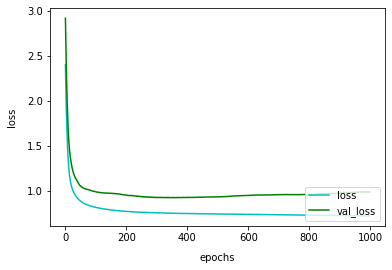

In [74]:
plt.plot(history.history['loss'], 'c', label= "loss")
plt.plot(history.history['val_loss'],'g', label= "val_loss")
plt.style.use('default')
plt.legend(loc="lower right")
plt.rcParams["figure.figsize"] = (15,5)

plt.xlabel('epochs', labelpad=10)
plt.ylabel('loss', labelpad=10)

In [98]:
ffnn_CMI = feed_forward(4)
ffnn_CMI.fit(X_train_valid.iloc[:,[0, 2, 3, 4, 7, 10, 11, 12]].values, y_train_valid, shuffle=False, epochs=200, verbose = 0)

ffnn_MAE = mean_absolute_error(y_test, ffnn_CMI.predict(X_test.iloc[:,[0, 2, 3, 4, 7, 10, 11, 12]].values))
ffnn_MSE = mean_squared_error(y_test, ffnn_CMI.predict(X_test.iloc[:,[0, 2, 3, 4, 7, 10, 11, 12]].values))

metric = RSquare()
metric.update_state(y_test, ffnn_CMI.predict(X_test.iloc[:,[0, 2, 3, 4, 7, 10, 11, 12]].values))
r2_test = metric.result()
r2_test.numpy()

metric = RSquare()
metric.update_state(y_train_valid, ffnn_CMI.predict(X_train_valid.iloc[:,[0, 2, 3, 4, 7, 10, 11, 12]].values))
r2_train = metric.result()
r2_train.numpy()
print (" FFNN with features from CMI:")
print(" MAE: ", round(ffnn_MAE,3), "\n", "MSE: ", round(ffnn_MSE,3), "\n",
      "R2_test: ",BOLD, round(r2_test.numpy(),3), END,"\n", "R2_train: ", round(r2_train.numpy(),3))

20/20 [==============================] - 0s 911us/step
 FFNN with features from CMI:
 MAE:  0.57 
 MSE:  0.502 
 R2_test:   0.271  
 R2_train:  0.24


In [77]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

ffnn_val = feed_forward(4)

history = ffnn_val.fit(X_train.iloc[:,[0, 2, 3, 4, 9, 10, 11, 1]].values, y_train.values, shuffle=False, epochs=1000, 
                        validation_data=(X_valid.iloc[:,[0, 2, 3, 4, 9, 10, 11, 1]].values, y_valid.values), verbose = 0)

Text(0, 0.5, 'loss')

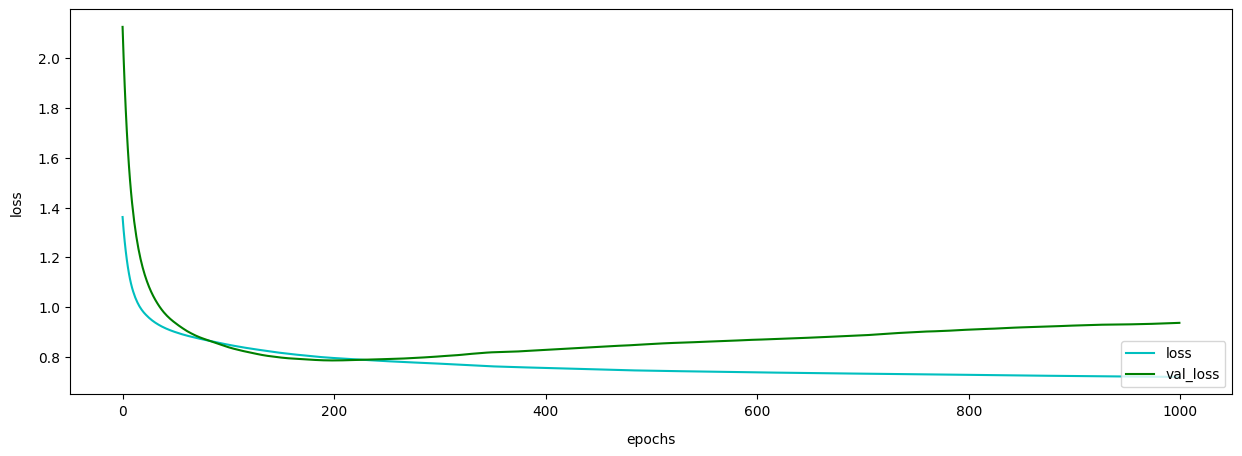

In [79]:
plt.plot(history.history['loss'], 'c', label= "loss")
plt.plot(history.history['val_loss'],'g', label= "val_loss")
plt.style.use('default')
plt.legend(loc="lower right")
plt.rcParams["figure.figsize"] = (15,5)

plt.xlabel('epochs', labelpad=10)
plt.ylabel('loss', labelpad=10)

In [91]:
tf.random.set_seed(221)

In [94]:
ffnn_wrap = feed_forward(4)
ffnn_wrap.fit(X_train_valid.iloc[:,[0, 2, 3, 4, 9, 10, 11, 1]].values, y_train_valid, shuffle=False, epochs=220, verbose = 0)

ffnn_MAE = mean_absolute_error(y_test, ffnn_wrap.predict(X_test.iloc[:,[0, 2, 3, 4, 9, 10, 11, 1]].values))
ffnn_MSE = mean_squared_error(y_test, ffnn_wrap.predict(X_test.iloc[:,[0, 2, 3, 4, 9, 10, 11, 1]].values))

metric = RSquare()
metric.update_state(y_test, ffnn_wrap.predict(X_test.iloc[:,[0, 2, 3, 4, 9, 10, 11, 1]].values))
r2_test = metric.result()
r2_test.numpy()

metric = RSquare()
metric.update_state(y_train_valid, ffnn_wrap.predict(X_train_valid.iloc[:,[0, 2, 3, 4, 9, 10, 11, 1]].values))
r2_train = metric.result()
r2_train.numpy()
print (" FFNN with features from wrapper:")
print(" MAE: ", round(ffnn_MAE,3), "\n", "MSE: ", round(ffnn_MSE,3), "\n",
      "R2_test: ", BOLD, round(r2_test.numpy(),3), END, "\n", "R2_train: ", round(r2_train.numpy(),3))

20/20 [==============================] - 0s 1ms/step
 FFNN with features from wrapper:
 MAE:  0.571 
 MSE:  0.5 
 R2_test:   0.274  
 R2_train:  0.261
